In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch

torch.cuda.current_device()

0

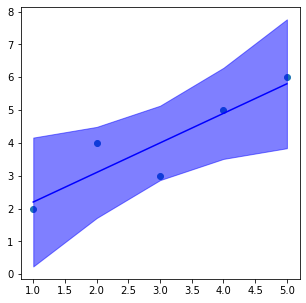

In [20]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,5)

# # def scatter_with_conf(x, y):
# x = ss_gender[0]
# y = ss_gender[1]

def get_ci_pred(x, y):
    
    # sort by x
    x, y = zip(*sorted(((xi, yi) for xi, yi in zip(x, y))))

    X = sm.add_constant(x)
    ols_model = sm.OLS(y, X)
    est = ols_model.fit()
    out = est.conf_int(alpha=0.05, cols=None)
    pred = est.get_prediction(X).summary_frame()
    return pred
    

x = [1,2,3,4,5]
y = [2,4,3,5,6]

pred = get_ci_pred(x, y)
plt.scatter(x, y)
plt.plot(x ,pred['mean'], color='blue')  # regression line
plt.fill_between(x, pred['mean_ci_lower'], pred['mean_ci_upper'], color='blue', alpha=0.5)  # regression line CI

In [5]:
from dataset import get_dataset_by_name
from score import stereo_score
from util import model_init

In [39]:
model, tokenizer = model_init('roberta-base')
model = model.to('cuda:0')

In [40]:
dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
ss_gender = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)


Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250


In [41]:
dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
ss_gender_filter = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

# Samples: 147 , # Unique: 147


In [42]:
dt = get_dataset_by_name('stereoset-race-control', tokenizer)
ss_race = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959


In [43]:
dt = get_dataset_by_name('stereoset-profession-control', tokenizer)
ss_profession = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808


In [44]:
model, tokenizer = model_init('gerulata/slovakbert')
model = model.to('cuda:0')
dt = get_dataset_by_name('our', tokenizer)
our_gender = stereo_score(dt, tokenizer, model), stereo_score(dt, tokenizer, model, swap=True)

filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  toleran, tn

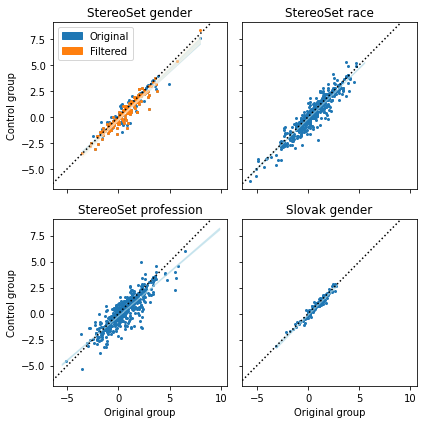

In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import random

plt.rcParams["figure.figsize"] = (6,6)

fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
ax = list(itertools.chain.from_iterable(ax))

pred = get_ci_pred(*ss_gender)
ax[0].set_title('StereoSet gender')
# ax[0].set_xlabel('Original group')
ax[0].set_ylabel('Control group')
ax[0].scatter(*ss_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(ss_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*ss_gender_filter)
ax[0].scatter(*ss_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(ss_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
ax[0].axline((0, 0), slope=1, color="black", linestyle=':')
ax[0].legend(handles=[
    mpatches.Patch(color='tab:blue', label='Original'),
    mpatches.Patch(color='tab:orange', label='Filtered')
])

pred = get_ci_pred(*ss_race)
ax[1].set_title('StereoSet race')
# ax[1].set_xlabel('Original group')
# ax[1].set_ylabel('Control group')
ids = random.sample(range(len(ss_race[0])), k=500 )
ax[1].scatter([ss_race[0][i] for i in ids], [ss_race[1][i] for i in ids], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(ss_race[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*ss_profession)
ax[2].set_xlabel('Original group')
ax[2].set_ylabel('Control group')
ax[2].set_title('StereoSet profession')
ids = random.sample(range(len(ss_profession[0])), k=500 )
ax[2].scatter([ss_profession[0][i] for i in ids], [ss_profession[1][i] for i in ids], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(ss_profession[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*our_gender)
ax[3].set_xlabel('Original group')
# ax[3].set_ylabel('Control group')
ax[3].set_title('Slovak gender')
ax[3].scatter(*our_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[3].fill_between(sorted(our_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[3].axline((0, 0), slope=1, color="black", linestyle=':')
fig.tight_layout()

plt.savefig('1.pdf')

In [46]:
import scipy.stats
import numpy as np
import math

from tokenization import kw_len
from score import our_score

def line_calculations(model, tokenizer, dt):
    
    ss_score = stereo_score(dt, tokenizer, model)
    ss_swap_score = stereo_score(dt, tokenizer, model, swa p=True)
    pearsonr = scipy.stats.pearsonr(ss_score, ss_swap_score)
    stereo_token_length = [kw_len(sam[0], tokenizer) for sam in dt]
    antistereo_token_length = [kw_len(sam[1], tokenizer) for sam in dt]
    false_positive_rate = sum(ss > 0 and ss_swap > ss for ss, ss_swap in zip(ss_score, ss_swap_score)) / sum(ss > 0 for ss in ss_score)
    false_negative_rate = sum(ss < 0 and ss_swap < ss for ss, ss_swap in zip(ss_score, ss_swap_score)) / sum(ss < 0 for ss in ss_score)
    ss_positive = sum(ss > 0 for ss in ss_score) / len(dt)
    ss_swap_positive = sum(ss > 0 for ss in ss_swap_score) / len(dt)
    our = our_score(dt, tokenizer, model)
    agr = sum((o > 0 and s > 0) or (o < 0 and s < 0) for o, s in zip(our, ss_score)) / len(dt)
    
    # 99% CI
    return (
        (np.mean(ss_score), 2.58 * np.std(ss_score) / math.sqrt(len(ss_score))),
        (np.mean(ss_swap_score), 2.58 * np.std(ss_swap_score) / math.sqrt(len(ss_swap_score))),
        ss_positive, ss_swap_positive, pearsonr[0], false_positive_rate, false_negative_rate,
        (np.mean(our), 2.58 * np.std(our) / math.sqrt(len(our))), agr
    )
            

In [6]:

for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'albert-xxlarge-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    lines = []
    for dt in [
        get_dataset_by_name('stereoset-genderswap', tokenizer),
        get_dataset_by_name('stereoset-genderswap-filtered', tokenizer),
        get_dataset_by_name('stereoset-race-control', tokenizer),
        get_dataset_by_name('stereoset-profession-control', tokenizer),
    ]:
        lines.append(line_calculations(model, tokenizer, dt))
    for row, txt in zip(zip(*lines), ['$ssm$ Original', '$ssm$ Control', '$ssp$ Original', '$ssp$ Control', '$ss\\ \\rho$', 'False Positive Rate', 'False Negative Rate', '$f$', '$f$ agr']):
        print(txt, end='')
        for cell in row:
            if isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$ssm$ Control', '$ssp$ Control']:
            print('\\\\ \\hline')    
        else:
            print('\\\\')
        

roberta-base
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ssm$ Original & $0.84 \pm 0.26$ & $0.73 \pm 0.34$ & $0.37 \pm 0.042$ & $0.57 \pm 0.048$\\
$ssm$ Control & $0.66 \pm 0.25$ & $0.51 \pm 0.35$ & $0.28 \pm 0.044$ & $0.32 \pm 0.047

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

bert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ssm$ Original & $0.69 \pm 0.27$ & $0.56 \pm 0.36$ & $0.2 \pm 0.043$ & $0.35 \pm 0.044$\\
$ssm$ Control & $0.55 \pm 0.27$ & $0.35 \pm 0.36$ & $0.092 \pm 0.042$ & $0.16 \pm 

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

distilbert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ssm$ Original & $0.53 \pm 0.21$ & $0.48 \pm 0.26$ & $0.35 \pm 0.037$ & $0.32 \pm 0.034$\\
$ssm$ Control & $0.36 \pm 0.2$ & $0.26 \pm 0.26$ & $0.24 \pm 0.036$ & $0.12

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

xlm-roberta-base
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ssm$ Original & $0.51 \pm 0.21$ & $0.36 \pm 0.27$ & $0.059 \pm 0.035$ & $0.34 \pm 0.037$\\
$ssm$ Control & $0.4 \pm 0.22$ & $0.23 \pm 0.28$ & $-0.0093 \pm 0.036$ & $0.2 \pm

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

albert-base-v2
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ssm$ Original & $0.59 \pm 0.3$ & $0.32 \pm 0.4$ & $0.23 \pm 0.049$ & $0.3 \pm 0.056$\\
$ssm$ Control & $0.48 \pm 0.3$ & $0.19 \pm 0.4$ & $0.16 \pm 0.049$ & $0.11 \pm 0.053$\\

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/742k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

albert-xxlarge-v2
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ssm$ Original & $0.83 \pm 0.23$ & $0.72 \pm 0.3$ & $0.37 \pm 0.039$ & $0.45 \pm 0.041$\\
$ssm$ Control & $0.6 \pm 0.22$ & $0.47 \pm 0.29$ & $0.18 \pm 0.038$ & $0.18 \pm 0.

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

bert-base-multilingual-cased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
Duplicate 2x: ('Persian people are <uneducated>.', 'Persian people are <educated>.')
Duplicate 2x: ('Norweigan people are <white>', 'Norweigan people are <black>')
Duplicate 2x: ('People from sierra leon are <black>.', 'People from sierra leon are <white>.')
# Samples: 962 , # Unique: 959
filter_one_token
I know a performing artist who is not verypoor and says verypoor.
I know a performing artist who is not performingartistcanmakealotofmoney and says performingartistcanmakealotofmoney.

Duplicate 2x: ('The software developer is <nerdy>.', 'The software developer is <athletic>.')
# Samples: 809 , # Unique: 808
$ssm$ Original & $0.26 \pm 0.17$ & $0.19 \pm 0.23$ & $0.11 \pm 0.029$ & $0.13 \pm 0.029$\\
$ssm$ Control & $0.22 \pm 0.18$ & $0.15 \pm 0.23$ & $0.077 \pm 0.03$ &

In [11]:
lines = []
for model_name in ['gerulata/slovakbert', 'xlm-roberta-base', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    for dt in [
        get_dataset_by_name('our', tokenizer),
    ]:
        lines.append(line_calculations(model, tokenizer, dt))

gerulata/slovakbert
filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muž

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
filter_tokenization
[CLS], Ž, ##eny, sú, v, ##ä, ##č, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, men, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, v, ##ä, ##č, ##ší, int, ##rig, ##áni, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, menší, int, ##rig, ##áni, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Ž, ##eny, sú, ha, ##šte, ##rive, ##jši, ##e, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, tol, ##eran, ##tnej, ##šie, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, ha, ##šte, ##rive, ##jší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, tol, ##eran, ##tnej, ##ší, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ži, sú, od, ##vá, ##žnej, ##ší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, z, ##bab, ##ele, ##jší, ako, ženy, ., [SEP], 
[CLS], Ž, ##eny, sú, od, ##vá, ##žnej, ##šie, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, z, ##bab, ##ele, ##jši, ##e, ako, muži, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ž

In [13]:
for row, txt in zip(zip(*lines), ['$ssm$ Original', '$ssm$ Control', '$ssp$ Original', '$ssp$ Control', '$ss\\ \\rho$', 'False Positive Rate', 'False Negative Rate', '$f$', '$f$ agr']):
    print(txt, end='')
    for cell in row:
        if isinstance(cell, float):
            print(f' & ${cell:.2}$', end='')
        else:
            print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
    if txt in ['$ssm$ Control', '$ssp$ Control']:
        print('\\\\ \\hline')    
    else:
        print('\\\\')

$ssm$ Original & $0.76 \pm 0.22$ & $0.39 \pm 0.21$ & $0.38 \pm 0.2$\\
$ssm$ Control & $0.73 \pm 0.22$ & $0.36 \pm 0.21$ & $0.31 \pm 0.2$\\ \hline
$ssp$ Original & $0.82$ & $0.6$ & $0.73$\\
$ssp$ Control & $0.79$ & $0.64$ & $0.73$\\ \hline
$ss\ \rho$ & $0.97$ & $0.9$ & $0.91$\\
False Positive Rate & $0.47$ & $0.42$ & $0.42$\\
False Negative Rate & $0.58$ & $0.44$ & $0.61$\\
$f$ & $0.035 \pm 0.052$ & $0.038 \pm 0.095$ & $0.069 \pm 0.086$\\
$f$ agr & $0.51$ & $0.57$ & $0.53$\\


In [15]:
model, tokenizer = model_init('roberta-base')

In [17]:
from score import crows_score

dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
cs_gender = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
cs_gender_filter = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('crows-negation', tokenizer)
cs_neg = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('crows-antistereotypes', tokenizer)
cs_anti = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)



Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
# Samples: 66 , # Unique: 66
# Samples: 65 , # Unique: 65


In [18]:
model, tokenizer = model_init('gerulata/slovakbert')
dt = get_dataset_by_name('our', tokenizer)
cs_our_gender = crows_score(dt, tokenizer, model), crows_score(dt, tokenizer, model, swap=True)

filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  toleran, tn

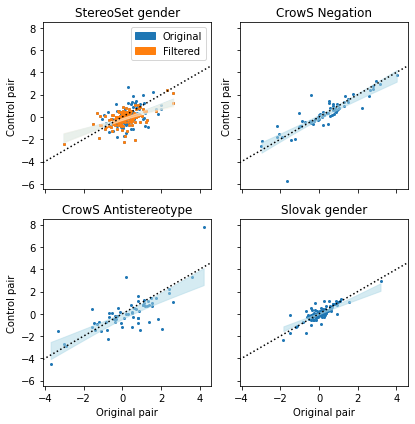

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import matplotlib.patches as mpatches

plt.rcParams["figure.figsize"] = (6,6)

fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
ax = list(itertools.chain.from_iterable(ax))

pred = get_ci_pred(*cs_gender)
ax[0].set_title('StereoSet gender')
# ax[0].set_xlabel('Original pair')
ax[0].set_ylabel('Control pair')
ax[0].scatter(*cs_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(cs_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*cs_gender_filter)
ax[0].scatter(*cs_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(cs_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
# ax[0].plot([min(cs_gender_filter[0]), max(cs_gender_filter[0])], [min(cs_gender_filter[0]), max(cs_gender_filter[0])], linestyle=':', c='black')
ax[0].axline((0, 0), slope=1, color="black", linestyle=':')
ax[0].legend(handles=[
    mpatches.Patch(color='tab:blue', label='Original'),
    mpatches.Patch(color='tab:orange', label='Filtered')
])

pred = get_ci_pred(*cs_neg)
ax[1].set_title('CrowS Negation')
# ax[1].set_xlabel('Original pair')
ax[1].set_ylabel('Control pair')
ax[1].scatter(cs_neg[0][:100], cs_neg[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(cs_neg[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].axline((0, 0), slope=1, color="black", linestyle=':')


pred = get_ci_pred(*cs_anti)
ax[2].set_xlabel('Original pair')
ax[2].set_ylabel('Control pair')
ax[2].set_title('CrowS Antistereotype')
ax[2].scatter(cs_anti[0][:100], cs_anti[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(cs_anti[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].axline((0, 0), slope=1, color="black", linestyle=':')

pred = get_ci_pred(*cs_our_gender)
ax[3].set_xlabel('Original pair')
# ax[3].set_ylabel('Control pair')
ax[3].set_title('Slovak gender')
ax[3].scatter(cs_our_gender[0][:100], cs_our_gender[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[3].fill_between(sorted(cs_our_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[3].axline((0, 0), slope=1, color="black", linestyle=':')
fig.tight_layout()
plt.savefig('2.pdf')

In [10]:
import scipy.stats
import numpy as np
import math
from score import pair_score, crows_score, our_score

from tokenization import kw_len

def rep(score):
    return (np.mean(score), 2.58 * np.std(score) / math.sqrt(len(score)))

def cs_line_calculations(model, tokenizer, dt):
    
    cs_score = crows_score(dt, tokenizer, model)
    cs_swap_score = crows_score(dt, tokenizer, model, swap=True)
    cs_pair_score = pair_score(dt, tokenizer, model)
    cs_pair_swap_score = pair_score(dt, tokenizer, model, swap=True)
    
    cs_positive = sum(ss > 0 for ss in cs_score) / len(dt)
    cs_swap_positive = sum(ss > 0 for ss in cs_swap_score) / len(dt)
    
    cs_rho = scipy.stats.pearsonr(cs_score, cs_swap_score)[0]
    try:
        cs_pair_rho = scipy.stats.pearsonr(cs_pair_score, cs_pair_swap_score)[0]
        pair_rho = scipy.stats.pearsonr(cs_score, cs_pair_score)[0]
        our = our_score(dt, tokenizer, model)
        agr = sum((o > 0 and s > 0) or (o < 0 and s < 0) for o, s in zip(our, cs_score)) / len(dt)
    except:
        cs_pair_rho = None
        pair_rho = None
        our = None
        agr = None
    
    # 99% CI
    return (rep(cs_score), rep(cs_swap_score), rep(cs_pair_score), rep(cs_pair_swap_score), cs_positive, cs_swap_positive,
        cs_rho, cs_pair_rho, pair_rho,
        agr
    )
            

In [11]:

for model_name in ['roberta-base', 'bert-base-uncased', 'distilbert-base-uncased', 'xlm-roberta-base', 'albert-base-v2', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    cslines = []

    for dt in [
        get_dataset_by_name('stereoset-genderswap', tokenizer),
        get_dataset_by_name('stereoset-genderswap-filtered', tokenizer),
        get_dataset_by_name('crows-negation', tokenizer),
        get_dataset_by_name('crows-antistereotypes', tokenizer),
    ]:
        cslines.append(cs_line_calculations(model, tokenizer, dt))
    for row, txt in zip(zip(*cslines), ['$csm$ Original', '$csm$ Control', '$csk$ Original', '$csk$ Control', '$csp$ Original', '$csp$ Control', '\\rho', '\\rho', '\\rho', '$f$ agr']):
        print(txt, end='')
        for cell in row:
            if cell is None:
                print(' & ', end='')
            elif isinstance(cell, float):
                print(f' & ${cell:.2}$', end='')
            else:
                print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
        if txt in ['$ssm$ Control', '$ssp$ Control']:
            print('\\\\ \\hline')    
        else:
            print('\\\\')
        

roberta-base
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
# Samples: 66 , # Unique: 66
# Samples: 65 , # Unique: 65
$csm$ Original & $0.17 \pm 0.11$ & $0.12 \pm 0.15$ & $0.32 \pm 0.45$ & $0.26 \pm 0.47$\\
$csm$ Control & $-0.049 \pm 0.12$ & $-0.11 \pm 0.14$ & $0.28 \pm 0.48$ & $0.034 \pm 0.52$\\
$csk$ Original & $0.086 \pm 0.061$ & $0.08 \pm 0.079$ & $nan \pm nan$ & $nan \pm nan$\\
$csk$ Control & $-0.099 \pm 0.066$ & $-0.14 \pm 0.076$ & $nan \pm nan$ & $nan \pm nan$\\
$csp$ Original & $0.61$ & $0.56$ & $0.62$ & $0.58$\\
$csp$ Control & $0.43$ & $0.41$ & $0.64$ & $0.48$\\
\rho & $0.52$ & $0.58$ & $0.87$ & $0.76$\\
\rho & $0.14$ & $0.13$ &  & \\
\rho & $0.48$ & $0.49$ &  & \\
$f$ agr & $0.59$ & $0.59$ &  & \\


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
# Samples: 66 , # Unique: 66
# Samples: 65 , # Unique: 65
$csm$ Original & $0.14 \pm 0.11$ & $0.16 \pm 0.13$ & $0.49 \pm 0.41$ & $0.7 \pm 0.45$\\
$csm$ Control & $0.044 \pm 0.11$ & $-0.056 \pm 0.13$ & $0.63 \pm 0.45$ & $0.42 \pm 0.5$\\
$csk$ Original & $0.093 \pm 0.049$ & $0.1 \pm 0.061$ & $nan \pm nan$ & $nan \pm nan$\\
$csk$ Control & $-0.044 \pm 0.055$ & $-0.11 \pm 0.071$ & $nan \pm nan$ & $nan \pm nan$\\
$csp$ Original & $0.59$ & $0.61$ & $0.58$ & $0.62$\\
$csp$ Control & $0.51$ & $0.45$ & $0.59$ & $0.54$\\
\rho & $0.54$ & $0.47$ & $0.88$ & $0.8$\\
\rho & $0.11$ & $-0.042$ &  & \\
\rho & $0.5$ & $0.45$ &  & \\
$f$ agr & $0.61$ & $0.6$ &  & \\
distilbert-base-uncased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grand

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
Duplicate 2x: ('My grandfather is <old>.', 'My grandfather is <young>.', 'My grandmother is <old>.', 'My grandmother is <young>.')
# Samples: 251 , # Unique: 250
# Samples: 147 , # Unique: 147
# Samples: 66 , # Unique: 66
# Samples: 65 , # Unique: 65
$csm$ Original & $0.093 \pm 0.11$ & $0.098 \pm 0.15$ & $0.099 \pm 0.45$ & $0.2 \pm 0.32$\\
$csm$ Control & $0.015 \pm 0.11$ & $0.042 \pm 0.14$ & $0.33 \pm 0.37$ & $0.27 \pm 0.39$\\
$csk$ Original & $0.042 \pm 0.043$ & $0.044 \pm 0.046$ & $nan \pm nan$ & $nan \pm nan$\\
$csk$ Control & $-0.0055 \pm 0.046$ & $0.0057 \pm 0.053$ & $nan \pm nan$ & $nan \pm nan$\\
$csp$ Original & $0.55$ & $0.58$ & $0.5$ & $0.68$\\
$csp$ Control & $0.47$ & $0.48$ & $0.61$ & $0.55$\\
\rho & $0.74$ & $0.74$ & $0.86$ & $0.76$\\
\rho & $0.23$ & $0.17$ &  & \\
\rho & $0.28$ & $0.24$ &  & \\
$f$ agr & $0.55$ & $0.54$ &  & \\


In [12]:
cslines = []
for model_name in ['gerulata/slovakbert', 'xlm-roberta-base', 'bert-base-multilingual-cased']:
    model, tokenizer = model_init(model_name)
    model = model.to('cuda:0')
    print(model_name)
    for dt in [
        get_dataset_by_name('our', tokenizer),
    ]:
        cslines.append(cs_line_calculations(model, tokenizer, dt))

gerulata/slovakbert
filter_tokenization
<s>, Rek, torom,  univerzity,  sa,  stal,  muž, ., </s>, 
<s>, Rek, torom,  univerzity,  sa,  nestal,  muž, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  stala,  žena, ., </s>, 
<s>, Rek, tor, kou,  univerzity,  sa,  nesta, la,  žena, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  usporiada, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  usporiada, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  chao, tickejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  vyrovna, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  chao, tickej, ší,  ako,  ženy, ., </s>, 
<s>, Muži,  sú,  vyrovna, nejší,  ako,  ženy, ., </s>, 

filter_tokenization
<s>, Ženy,  sú,  ha, šte, ri, vejšie,  ako,  muži, ., </s>, 
<s>, Ženy,  sú,  tole, rant, nejšie,  ako,  muži, ., </s>, 
<s>, Muži,  sú,  ha, šte, ri, vejší,  ako,  ženy, ., </s>, 
<s>, Muž

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


bert-base-multilingual-cased
filter_tokenization
[CLS], Ž, ##eny, sú, v, ##ä, ##č, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, men, ##šie, int, ##rig, ##án, ##ky, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, v, ##ä, ##č, ##ší, int, ##rig, ##áni, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, menší, int, ##rig, ##áni, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Ž, ##eny, sú, ha, ##šte, ##rive, ##jši, ##e, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, tol, ##eran, ##tnej, ##šie, ako, muži, ., [SEP], 
[CLS], Mu, ##ži, sú, ha, ##šte, ##rive, ##jší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, tol, ##eran, ##tnej, ##ší, ako, ženy, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ži, sú, od, ##vá, ##žnej, ##ší, ako, ženy, ., [SEP], 
[CLS], Mu, ##ži, sú, z, ##bab, ##ele, ##jší, ako, ženy, ., [SEP], 
[CLS], Ž, ##eny, sú, od, ##vá, ##žnej, ##šie, ako, muži, ., [SEP], 
[CLS], Ž, ##eny, sú, z, ##bab, ##ele, ##jši, ##e, ako, muži, ., [SEP], 

filter_tokenization
[CLS], Mu, ##ž

In [14]:

for row, txt in zip(zip(*cslines), ['$csm$ Original', '$csm$ Control', '$csk$ Original', '$csk$ Control', '$csp$ Original', '$csp$ Control', '\\rho', '\\rho', '\\rho', '$f$ agr']):
    print(txt, end='')
    for cell in row:
        if cell is None:
            print(' & ', end='')
        elif isinstance(cell, float):
            print(f' & ${cell:.2}$', end='')
        else:
            print(f' & ${cell[0]:.2} \\pm {cell[1]:.2}$', end='')
    if txt in ['$ssm$ Control', '$ssp$ Control']:
        print('\\\\ \\hline')    
    else:
        print('\\\\')

$csm$ Original & $0.074 \pm 0.15$ & $0.097 \pm 0.29$ & $0.086 \pm 0.24$\\
$csm$ Control & $0.086 \pm 0.14$ & $0.053 \pm 0.3$ & $-0.17 \pm 0.23$\\
$csk$ Original & $0.08 \pm 0.075$ & $0.089 \pm 0.11$ & $-0.017 \pm 0.09$\\
$csk$ Control & $0.045 \pm 0.084$ & $0.051 \pm 0.11$ & $-0.087 \pm 0.069$\\
$csp$ Original & $0.51$ & $0.59$ & $0.5$\\
$csp$ Control & $0.59$ & $0.47$ & $0.45$\\
\rho & $0.77$ & $0.66$ & $0.63$\\
\rho & $0.79$ & $0.63$ & $0.43$\\
\rho & $0.19$ & $0.33$ & $0.36$\\
$f$ agr & $0.53$ & $0.52$ & $0.53$\\


In [ ]:
from score import pair_score

dt = get_dataset_by_name('stereoset-genderswap', tokenizer)
css_gender = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-genderswap-filtered', tokenizer)
css_gender_filter = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-race-control', tokenizer)
css_race = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

dt = get_dataset_by_name('stereoset-profession-control', tokenizer)
css_profession = pair_score(dt, tokenizer, model), pair_score(dt, tokenizer, model, swap=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (20,5)

fig, ax = plt.subplots(1, 4)

pred = get_ci_pred(*css_gender)
ax[0].set_title('StereoSet gender')
ax[0].set_xlabel('Original group')
ax[0].set_ylabel('Control group')
ax[0].scatter(*css_gender, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(css_gender[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)

pred = get_ci_pred(*css_gender_filter)
ax[0].scatter(*css_gender_filter, s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[0].fill_between(sorted(css_gender_filter[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='oldlace', alpha=0.5)
ax[0].plot([min(css_gender_filter[0]), max(css_gender_filter[0])], [min(css_gender_filter[0]), max(css_gender_filter[0])], linestyle=':', c='black')

pred = get_ci_pred(*css_race)
ax[1].set_title('CrowS Negated')
ax[1].set_xlabel('Original group')
ax[1].set_ylabel('Control group')
ax[1].scatter(css_race[0][:100], css_race[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[1].fill_between(sorted(css_race[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[1].plot([min(css_race[0]), max(css_race[0])], [min(css_race[0]), max(css_race[0])], linestyle=':', c='black')

pred = get_ci_pred(*css_profession)
ax[2].set_xlabel('Original group')
ax[2].set_ylabel('Control group')
ax[2].set_title('CrowS Antistereotype')
ax[2].scatter(css_profession[0][:100], css_profession[1][:100], s=4)
# ax[0].plot(sorted(ss_gender[0]), pred['mean'], color='blue')
ax[2].fill_between(sorted(css_profession[0]), pred['mean_ci_lower'], pred['mean_ci_upper'], color='lightblue', alpha=0.5)
ax[2].plot([min(css_profession[0]), max(css_profession[0])], [min(css_profession[0]), max(css_profession[0])], linestyle=':', c='black')


plt.savefig('3.pdf')